##### Artur Bandura
##### Adam Fedoruk

# Identity-based Encryption
Identity-based Encryptin to rodzaj szyfrowania z kluczem publicznym, w którym kluczem publicznym użytkownika jest pewna unikalna informacja o jego tożsamości (np. adres email). To oznacza, że osoba któa wysyła wiadomość musi posiadać dostęp do publicznych parametrów sytemu. Dzięki temu może zaszyfrować wiadomość przykładowo przy użyciu adresu e-mail adresata jako klucza. Odbiorca uzyskuje prywatny klucz deszyfrujący od zaufanego podmiotu, który generuje klucze prywatne dla każdego użytkownika systemu.

##### Infrastruktura Klucza Publicznego a Identity-based Encryption

                                                                                                                            Adresat posiada identyfikator I
                                                                                                                            I = bob@example.com

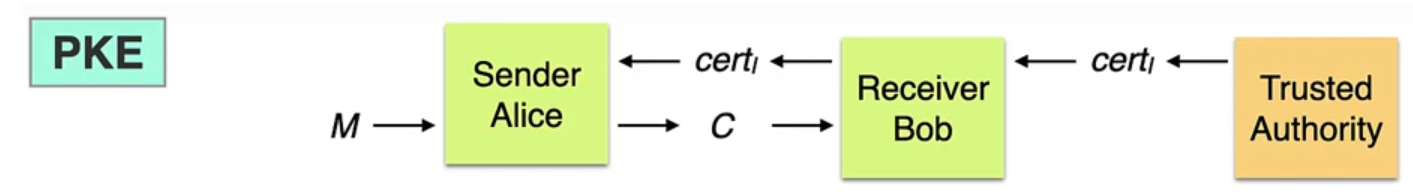

Adresat generuje własną parę kluczy (pk, sk)
Zaufany organ - Urząd Certyfikacji (ang. CA) otrzymując klucz publiczny, dostarcza adresatowi certyfikat (cert_I).
Nadawca potrzebuje certyfikatu odbiorcy przed zaszyfrowaniem wiadomości.

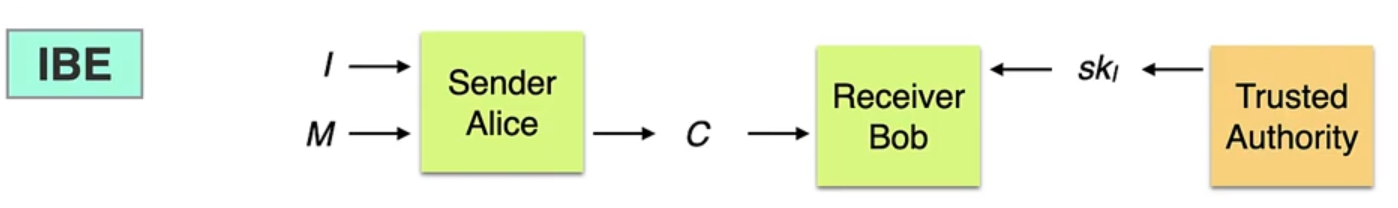

Adresat nie generuje nic a priori.
Nadawca potrzebuje tylko identyfikatora I przed zaszyfrowaniem wiadomości.
Zaufana trzecia strona (CA) otrzymując I, dostarcza odbiorcy klucz deszyfrujący (sk_I)

#### Jak działa IBE?

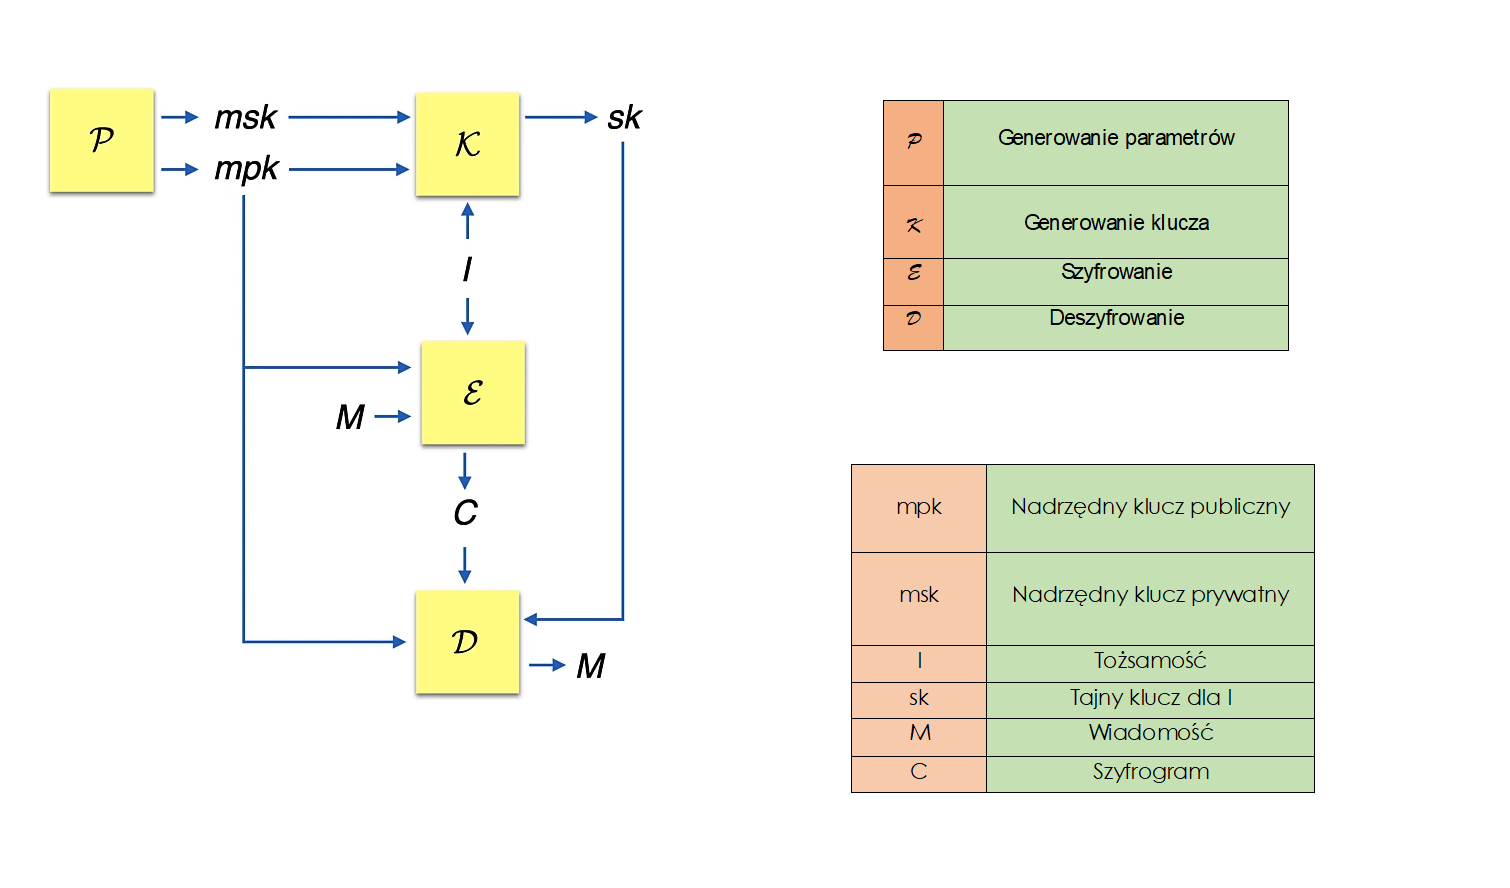

Generowane są następujące parametry: nadrzędny klucz prywatny oraz nadrzędny klucz publiczny.
Klucz tajny odbiorcy generowany jest za pomocą algorytmu, który jako argumenty przyjmuje wygenerowane wcześniej nadrzędne klucze (prywatny i publiczny) oraz identyfikator odbiorcy.

Algorytm szyfrujący przyjmuje trzy argumenty: wiadomość, nadrzędny klucz publiczny oraz identyfikator odbiorcy.

Algorytm deszyfrujący przyjmuje trzy argumenty: szyfrogram, nadrzędny klucz publiczny oraz klucz tajny adresata.

#### Bezpieczeństwo IBE

Aby system IBE spełniał swoje zadanie, adwersarz nie może dowiedzieć się niczego o wiadomości, gdy posiada szyfrogram, nadrzędny klucz publiczny oraz identyfikator odbiorcy. Jeśli adwersarz uzyska klucz tajny osoby, która nie jest celem ataku, nie powinno mu to pomóc w odszyfrowaniu wiadomości. Dla każdej tożsamości tworzony jest unikalny klucz tajny. Klucze nie mogą się powtarzać.

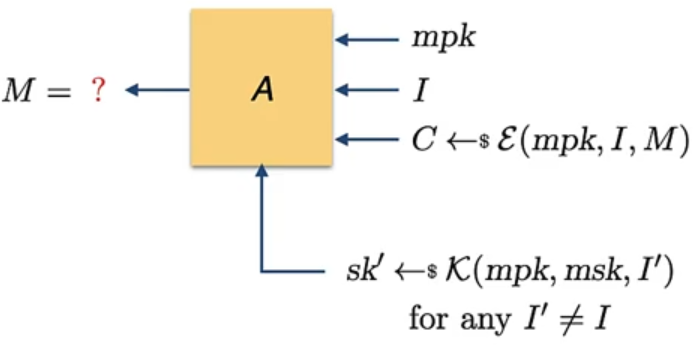

##### Trochę historii...
Identity-based encryption zostało zaproponowane w 1984 roku przez Adiego Shamira. Potrafił on jednak tylko podać przykład podpisu opartego na tożsamości (identity-based signature). Przez wiele lat Identity-based encryption pozostawało nierozwiązanym problemem. W 2001 roku pojawiły się dwa schematy, które rozwiązały ten problem:

- Schemat Boneh-Franklina oparty na parowaniu

- Schemat Cocks'a oparty na resztach kwadratowych

##### Trochę algebry...

##### Krzywe eliptyczne

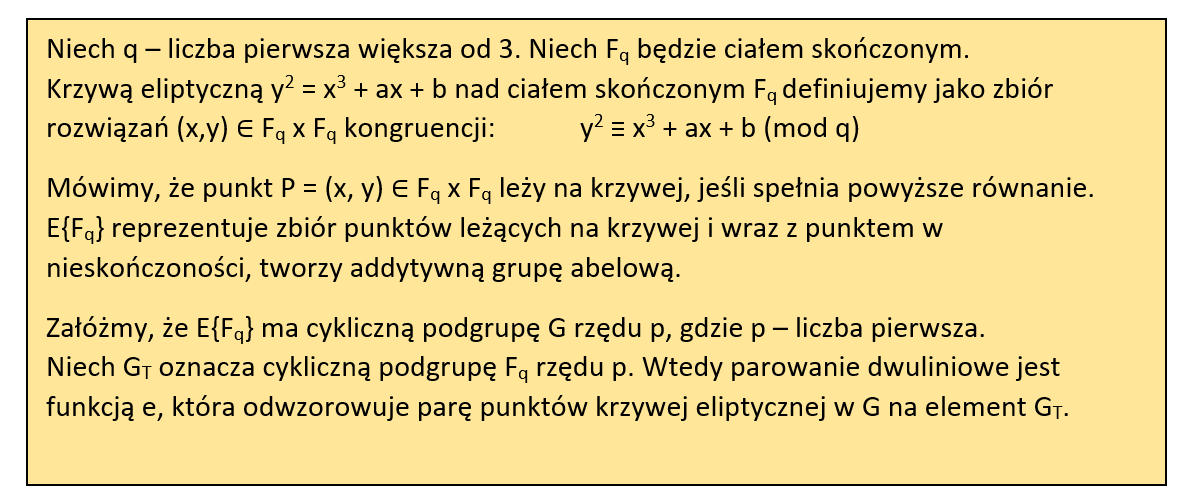

##### Parowanie
(W poniższych definicjach Zp oznacza ciało skończone)

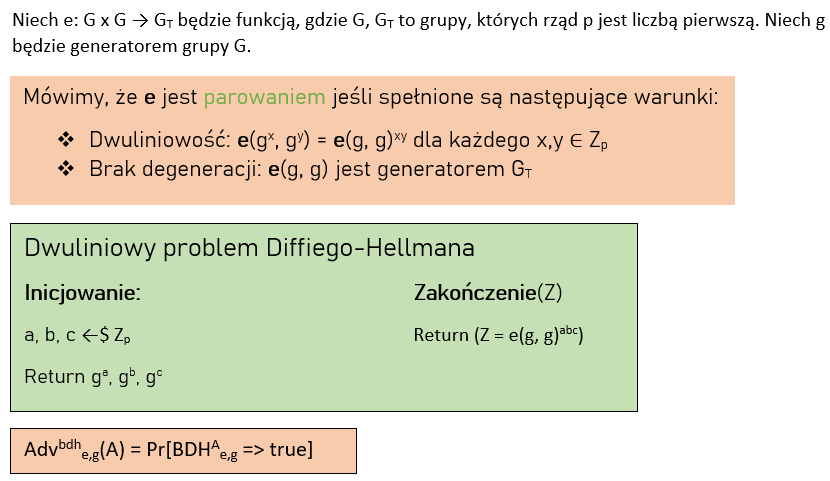

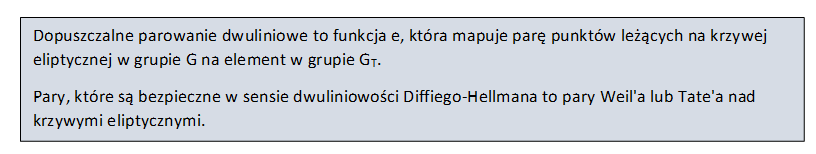

### Schemat Boneh-Franklina

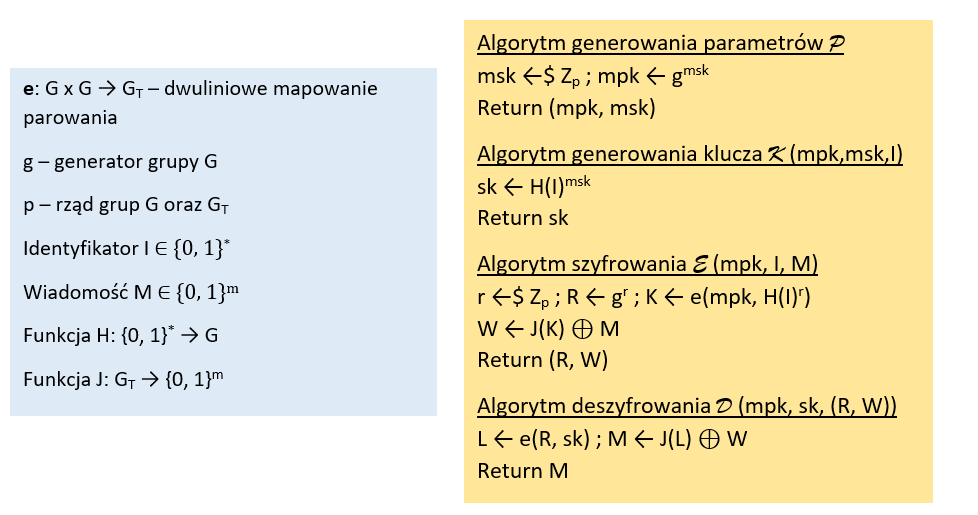

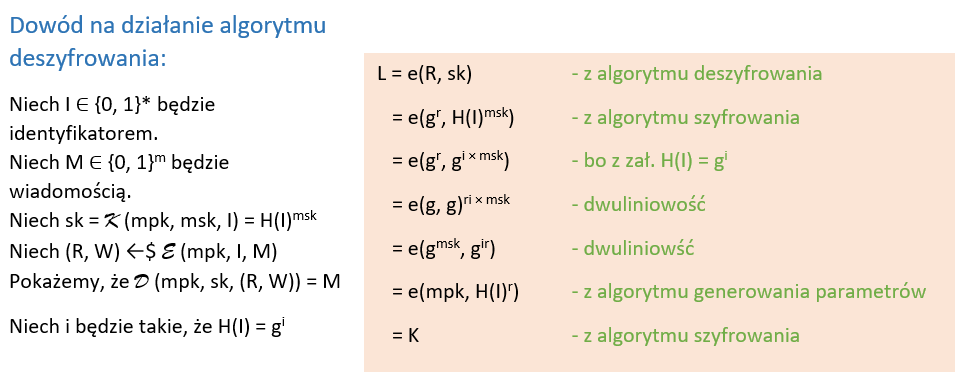

In [6]:
#Podstawowa implementacja schematu Boneh-Franklin
import random
from sage.crypto.cryptosystem import PublicKeyCryptosystem
from sage.all import EllipticCurve
from sage.all import Hom
from sage.all import Zmod, FiniteField, Integer
from copy import deepcopy

class BasicIdent(PublicKeyCryptosystem):
    """
    The Basic Identity Scheme proposed by Boneh and Franklin. 
    This scheme needs an Elliptic Curve over a finite field, a point of order n, and a distortion map.
    
    PARAMETERS:
        
        * ec: An elliptic curve over a finite field.
        * P: A point of finite order.
        * dmap: A distortion map
        * (Optional) order: Order of P.
        * (Optional) pairing: Which pairing will be used? "weil" (default) or "tate".
        * (Optional) k: Embedding degree of P in ec.
        * (Optional) seed: Seed to generate pseudorandom integers (by default it will use the default option of random.seed)
    """
    
    def __init__(self, ec, P = None, dmap = None, order = None, pairing="weil", k = None, seed=None):
        self.ec = ec
        self.P = P

        self.distortion = self._deco(dmap)
        if dmap == None:
            self.distortion = self._ext

        if order == None:
            self.order = P.order()
        else:
            self.order = order

        self.pairing = pairing

        ord = self.ec.base_ring().cardinality()
        if k == None:
            k = Zmod(self.order)(ord).multiplicative_order()
        self.k = k

        random.seed(seed)
        self.t = random.randint(2, self.order-1)

        base = FiniteField(ord**self.k, 'b')
        self.hom = Hom(self.ec.base_ring(), base)(base.gen()**((ord**self.k-1)/(ord-1)))
        self.ec2 = EllipticCurve(map(int,self.ec.a_invariants())).change_ring(base)
        
    def _ext(self, P):
        # P is a point of E(F_q), and it should be of E(F_q^k)

        return self.ec2(map(self.hom, P))
        
    def _deco(self, map):
        def distortionmap(P):
            P = self._ext(P)
            return map(P)
        return distortionmap
        
    def H1(self, ID):
        try:
            mult = int(ID) % (self.order - 2)
        except:
            mult = 0
            for let in ID:
                mult = mult*256 % (self.order - 2)
                mult = (mult + ord(let)) % (self.order - 2)
        return (2+mult)*self.P
        
    def H2(self, element, length = 0):
        random.seed(hash(element))
        mask = [None]*length
        for i in xrange(length):
            mask[i] = random.choice([0, 1])
        return mask
            
    def _mask(self, message, element):
        mask = self.H2(element, len(message))
        cmsg = deepcopy(message)
        for i in xrange(len(message)):
            cmsg[i] = (message[i] + mask[i]) % 2
        return "".join(map(str,cmsg))
        
    def public_key(self, ID):
        return [self.H1(ID), self.t*self.P]
        
    def private_key(self, ID):
        return self.t*self.H1(ID)
        
    def encrypt(self, message, pubkey, seed=None, text=False):
        random.seed(seed)
        
        tmp = None
        if not text:
            tmp = Integer(message).digits(2)
        else:
            tmp = 0
            for let in message:
                tmp = tmp*256
                tmp = (tmp + ord(let))
                
            tmp = Integer(tmp).digits(2)
            
        tmp.reverse()

        r = random.randint(2, self.order-1)
        if self.pairing == "tate":
            pair = self._ext(pubkey[0]).tate_pairing(self.distortion(pubkey[1]), self.order, self.k, self.ec2.base_ring().cardinality())
        else:
            pair = self._ext(pubkey[0]).weil_pairing(self.distortion(pubkey[1]), self.order)
        
        print("Sin cifrar", tmp)
        return r*self.P, self._mask(tmp, pair**r)
        
    def decrypt(self, ciphertext, privatekey, text=False):
        if self.pairing == "tate":
            pair = self._ext(privatekey).tate_pairing(self.distortion(ciphertext[0]), self.order, self.k, self.ec2.base_ring().cardinality())
        else:
            pair = self._ext(privatekey).weil_pairing(self.distortion(ciphertext[0]), self.order)
            
        msg = int(self._mask(map(int, list(ciphertext[1])), pair), base=2)
        if text:
            msg = map(chr, Integer(msg).digits(256))
            msg.reverse()
            msg = "".join(msg)
        return msg


Zanim przejdziemy do schematu Cocks'a...
### Schemat Sakai-Kasahara
Schemat Sakai-Kasahara znany także jako Sakai-Kasahara Key Encryption Algorithm (SAKKE) to system identity-based encryption, któego twórcami są Ryuichi Sakai oraz Masao Kasahara. System został zaproponowany w 2003 roku. Jeden z niewielu komercyjnie wdrożonych schematów szyfrowania opartych na tożsamości. Tak jak schemat Boneh-Franklina opiera się na parowaniu nad krzywymi eliptycznnymi oraz ciałami skończonymi. Również w tym przypadku bezpieczeństwo algorytmu polega na problemie dwuliniowym Diffiego-Hellmana (BDH). Dowód bezpieczeństwa algorytmu został przedstawiony w 2005 roku przez Chen'a oraz Cheng'a.

Jak to wygląda w praktyce?

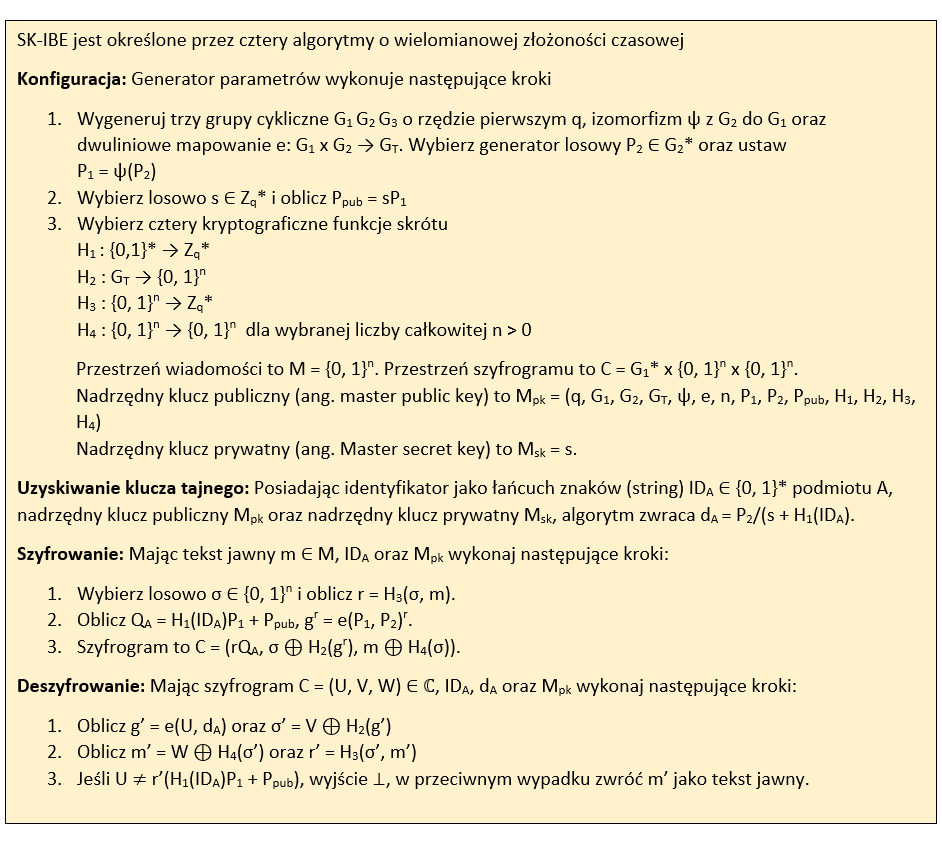

### Schemat Cocks'a

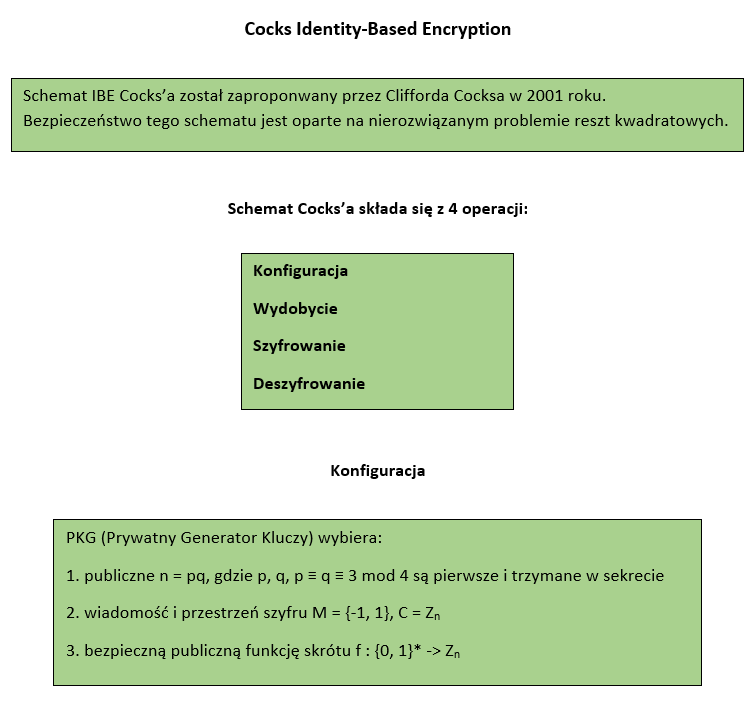

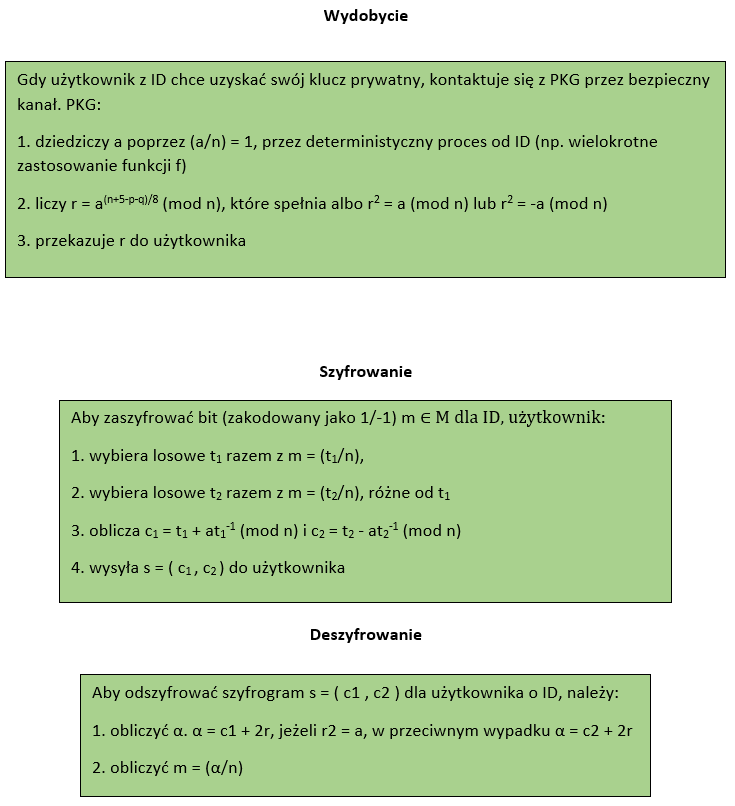

In [7]:
#Schemat Cocks'a
! pip install pycocks
! pip install bitarray
from cocks.cocks import CocksPKG, Cocks

cocks_pkg = CocksPKG()   # Optional param.: bit size (default = 2048)

# Extract private key, r, from an identity string; a transformed
# ID string, a, is also returned, which is required for encryption
# and decryption.
r, a = cocks_pkg.extract("User1")

cocks = Cocks(cocks_pkg.n)  # Must use same public modulus, n, from cocks_pkg
c = cocks.encrypt(b"Kryptografia", a)
msg = cocks.decrypt(c, r, a)  # => b"Kryptografia"
print("Ciphertext:", c)
print("Plaintext:", msg)

You should consider upgrading via the '/opt/sagemath-9.3/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/sagemath-9.3/local/bin/python3 -m pip install --upgrade pip' command.
Ciphertext: [(mpz(5528383492239416043308282247982654251508508391889674998353384465843443410493006363815354681713340336371387640073860419041160656180834099969164979718398773801898182253170825779474217991319769307903154241214796832830141541803345001005933856355199314378587379151582763540946074055873898905709872614492452902128574773810388715071066430787900118898803116678390318338144410131668596909483704475384331686021173309978271809246110694547153273705855331330594254348728082418501589132980507909344427640632289152050048233655165452925544662725260349790959804793858453302838997403333870289566862037255244872627516707897864957685308), mpz(10560827759508524367032843791007241122137131310704035167734157325241512338743038225516793812515646407015798372223465315169290423997

### SM9 - Chiński standard kryptograficzny
Algorytm SM9 został ogłoszony w marcu 2016 roku Chińskim standardem kryptograficznym dla identity-based cryptography. Definiuje zbiór schematów opierających się na parowaniu.

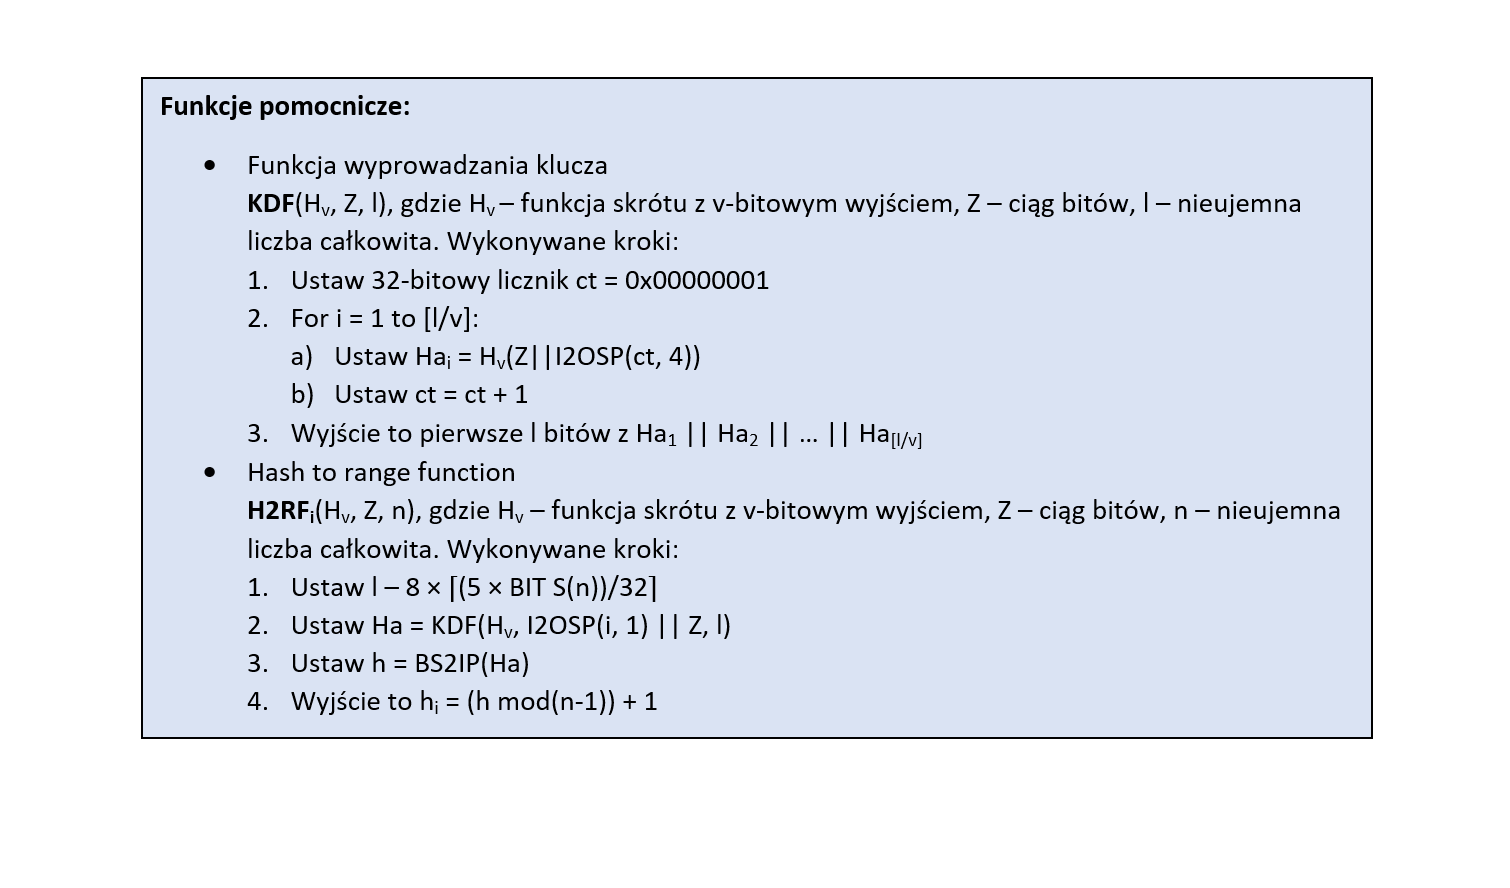

#### Identity-Based Signature

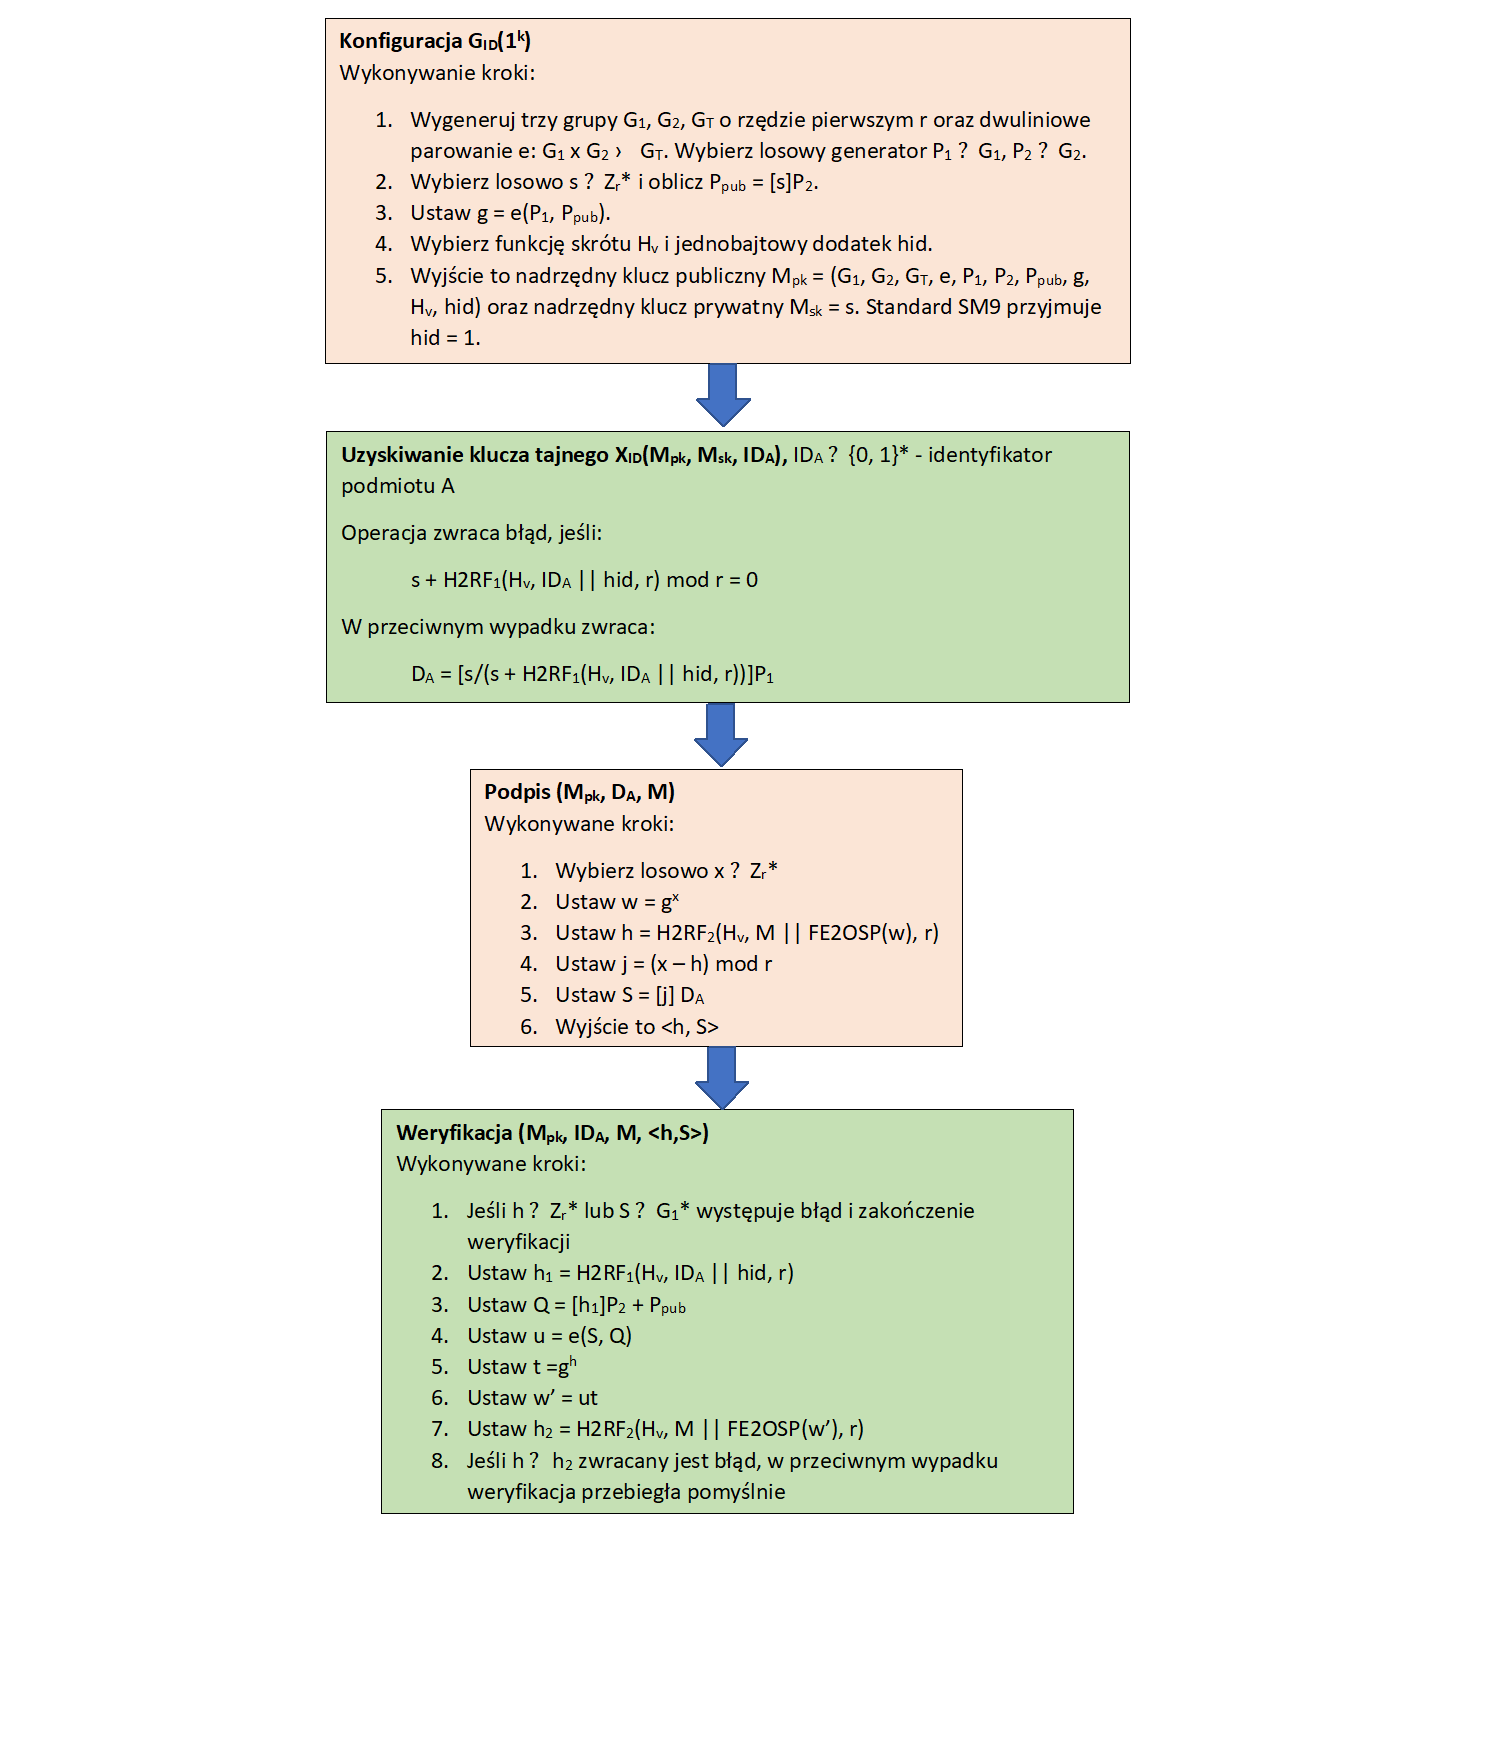

#### Identity-Based Key Agreement

SM9 Key Agreement (SM9-KA) jest dwuczęściowym algorytmem uzgadniania klucza. Schemat składa się z następujących opcji: Konfiguracja, Uzyskiwanie Klucza Tajnego, Wymiana Wiadomości, Generowanie Klucza Sesji i Potwierdzenie Klucza Sesji.

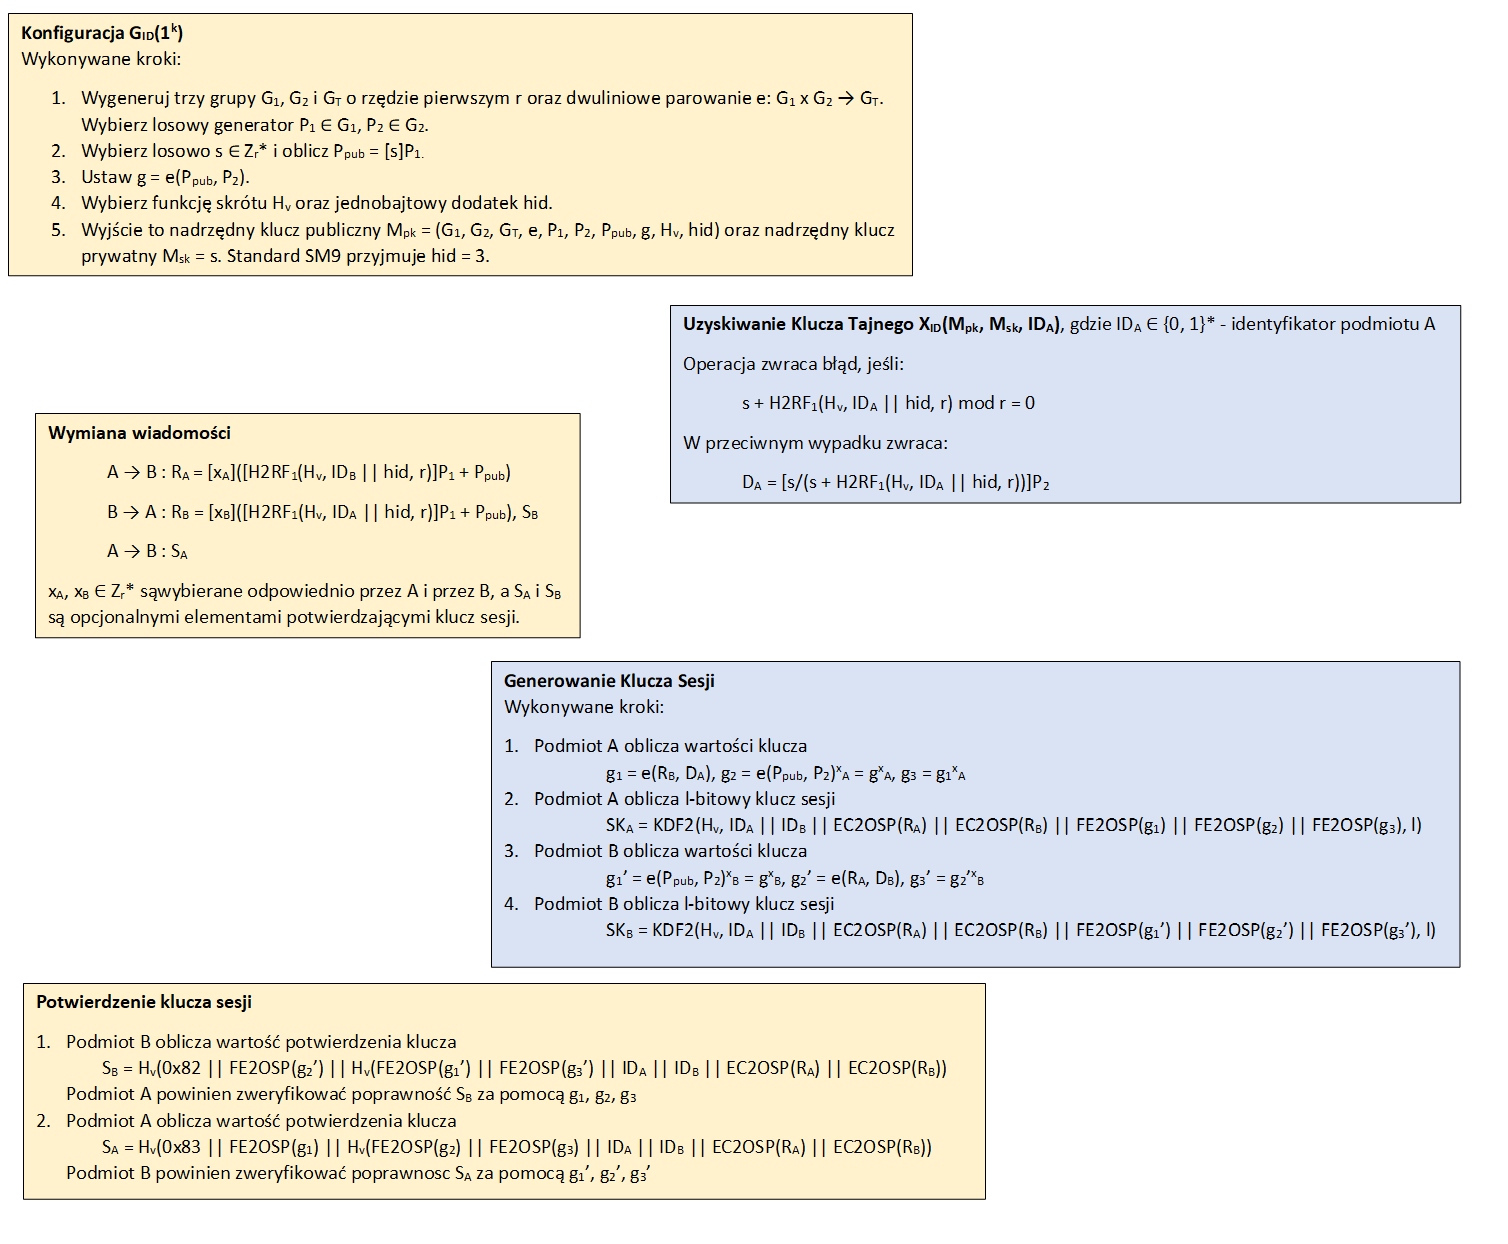

#### Identity-Based Encryption

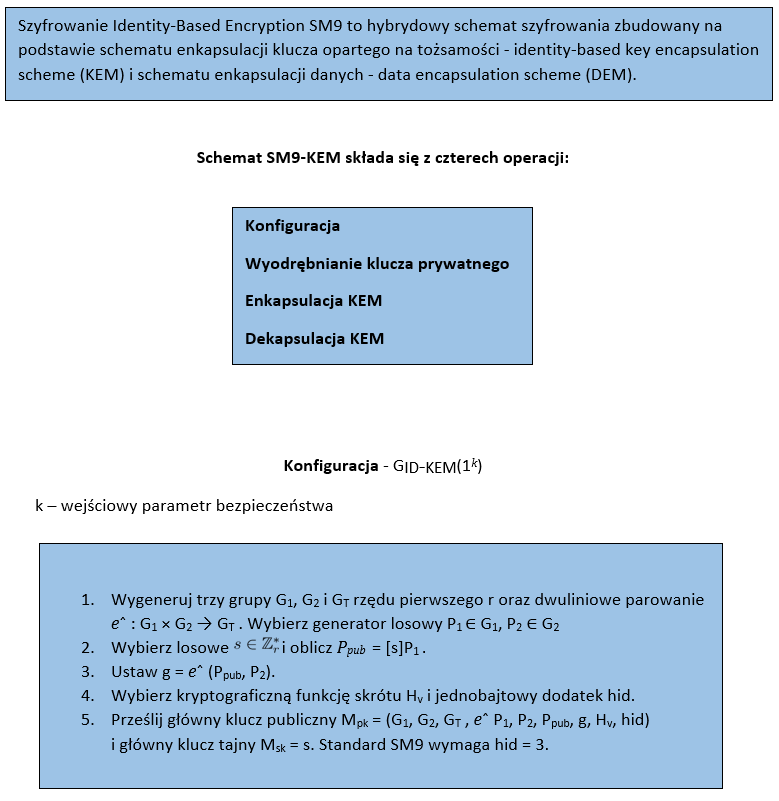

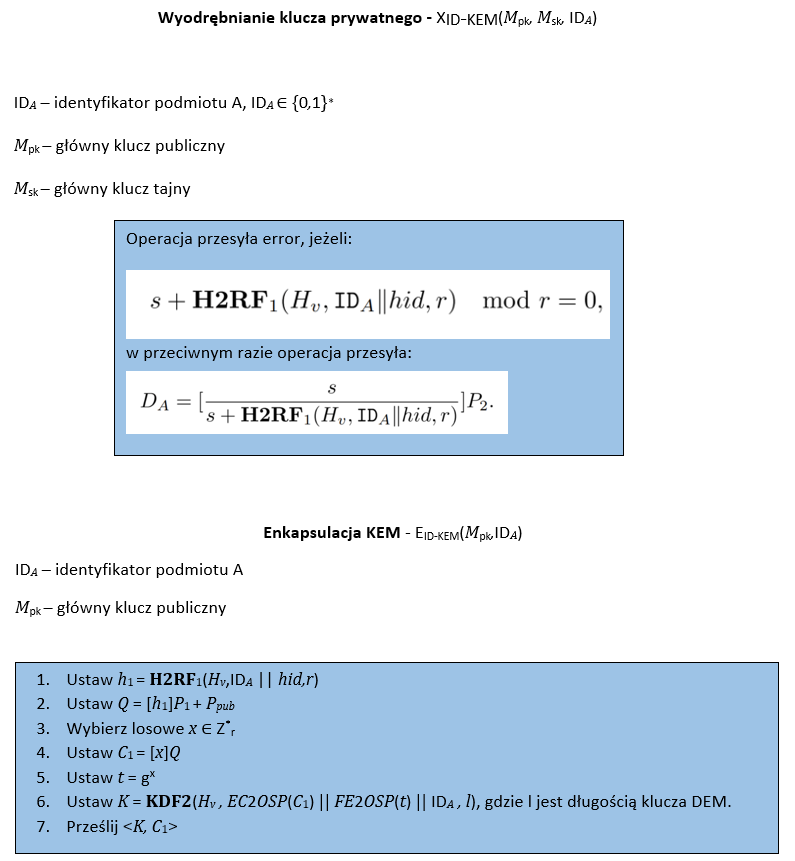

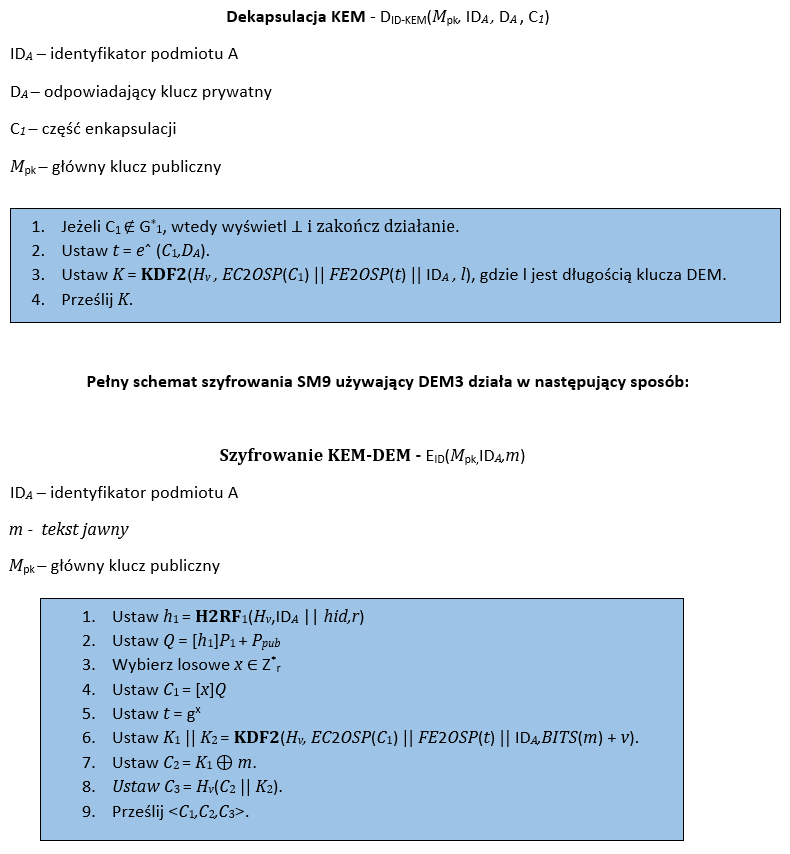

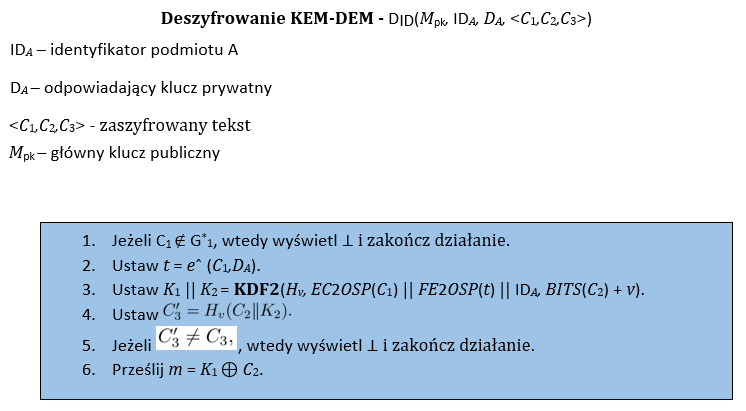

### Zastosowania
Identity-based cryptography jest rozwiązaniem głównie stosowanym w korporacjach. Zwłaszcza, gdy firmy korzystają z usług i aplikacjii dostarczanych przez inne strony trzecie do komunikacji personelu, przechowywania danych i zasobów obliczeniowych. Firmy mogą prowadzić własnr PKG, aby generować klucze prywatne dla swoich pracowników w celu zabezpieczenia ich komunikacji związanej z pracą i własności intelektualnej.

### Podsumowanie
##### Schemat Boneh-Franklin
Istnieje problem ze znalezieniem dokładniejszej dokumentacji modułu sage. Skutkiem tego jest trudność w utworzeniu konkretnych ciał skończonych i krzywej eliptycznej, które są niezbędne do stworzenia obiektu BasicIdent. W dodatku sam kod źródłowy nie zawiera więcej komentarzy autora i dokładniejszych wyjaśnień jak wykorzystać go w praktyce.
##### Schemat Cocks'a
Python posiada gotowy moduł o nazwie pycocks (niezbędny także moduł bitarray), dzięki któremu istnieje możliwość szyfrowania schematem Cocks'a. Zachodzi jednak problem ze znalezieniem dokumentacji biblioteki. Skutkiem tego jest przedstawienie tylko zaszyfrowanej i odszyfrowanej wiadomości bez dokładnego ukazania poszczególnych operacji schematu.
##### Schemat Sakai-Kasahara
Nie udało nam się znaleźć żadnej implementacji tego schematu.
##### Algorytm SM9
Można znaleźć różne przykłady algorytmów działających na takiej zasadzie jak SM9 m.in. w języku C# lub C. Pojawiają się jednak problemy z komentarzami, które w znacznej większości napisane są w języku chińskim. To znacznie utrudnia zrozumienie jak działa program.

Ze względu na złożoność schematów oraz niezbędną w przypadku Identity-based cryptography dużą wiedzę matematyczną, nie udało nam się napisać własnej implementacji.

